# Logistic Regression

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py

# Set random seed for reproducibility
np.random.seed(47)

### Classification data

#### 1.1 Custom data generation

In [121]:
def generate_classification_data(m=100, nx=2, noise=0.8, w1=2, w2=4, b=1):
    X = np.random.randn(m, nx)
    y = (X[:, 0]*w1 + X[:, 1]*w2 + b + np.random.randn(m) * noise > 0).astype(int)
    return X, y

def plot_classification_data(X, y):
    plt.figure(figsize=(6,4))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', label='class 1')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='b', label='class 0')
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.legend()
    plt.show()

#### 1.2 Get Standard data

In [122]:
from datasets import load_planar_dataset, load_extra_datasets

def get_std_dataset(name="noisy_moons", m=400):

    noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets(m)
    datasets = {"noisy_circles": noisy_circles,
                "noisy_moons": noisy_moons,
                "blobs": blobs,
                "gaussian_quantiles": gaussian_quantiles}
    
    if name not in datasets and name != "planar":
        raise ValueError("Dataset not found")
    if name == "planar":
        X, Y = load_planar_dataset(m)
        return X, Y
    else:
        X, Y = datasets[name]
        X, Y = X.T, Y.reshape(1, Y.shape[0])

        # make blobs binary
        if name == "blobs":
            Y = Y%2

        return X, Y
    
def plot_std_dataset(X, Y):
    plt.figure(figsize=(6,4))
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.show()

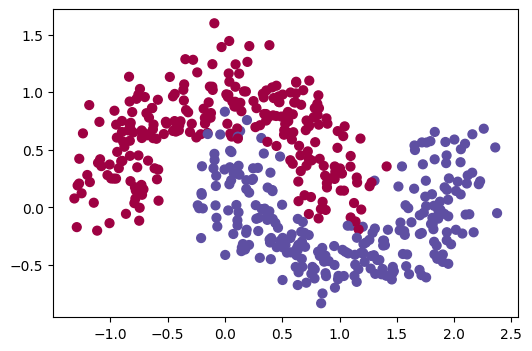

In [123]:
name = "noisy_moons"
m = 500
X, Y = get_std_dataset(name, m)
plot_std_dataset(X, Y)

### Building a Logistic Regression model

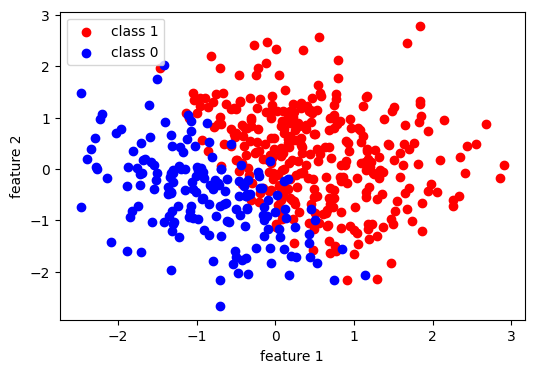

In [124]:
m = 500
nx = 4
X, y = generate_classification_data(m=500, nx=4, noise=0.9, w1=2.99, w2=1.99, b=1.5)
plot_classification_data(X, y)

In [125]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

In [126]:
def split_data(X, Y):
    # invert the shape for X_train and X_test and Y_train and Y_test
    # NOTE: This is the standard shape for the input data in the neural network
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train = X_train.T
    X_test = X_test.T
    y_train = y_train.reshape(1, y_train.shape[0])
    y_test = y_test.reshape(1, y_test.shape[0])

    # print the new shapes
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)


X_train shape: (4, 400)
y_train shape: (1, 400)
X_test shape: (4, 100)
y_test shape: (1, 100)


#### 1. Sigmoid

In [127]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1+np.exp(-z))
    return s

sigmoid(z) =  [4.53978687e-05 4.18766684e-04 3.85103236e-03 3.44451957e-02
 2.47663801e-01 7.52336199e-01 9.65554804e-01 9.96148968e-01
 9.99581233e-01 9.99954602e-01]


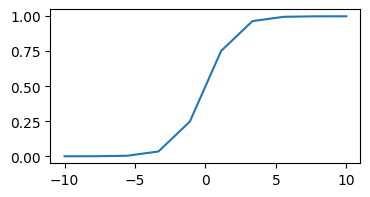

In [128]:
# test the sigmoid function
z = np.linspace(-10, 10, 10)
print("sigmoid(z) = ", sigmoid(z))

# plot the sigmoid function
plt.figure(figsize=(4,2))
plt.plot(z, sigmoid(z))
plt.show()

#### 2. Initialize weights and bias

In [129]:
def initialize_with_zeros(X):
    """
    This function creates a vector of zeros of shape (X.shape[0], 1) for w and initializes b to 0.
    
    Argument:
    X.shape[0] -- size of the w vector we want (or number of parameters in this case). this is the number of features in the input data
    
    Returns:
    w -- initialized vector of shape (X.shape[0], 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((X.shape[0], 1)) 
    b = 0.0
    return w, b

In [130]:
# test the initialize_with_zeros function
w, b = initialize_with_zeros(X_train)
print("w = ", w)
print("b = ", b)
print("w shape:", w.shape)

w =  [[0.]
 [0.]
 [0.]
 [0.]]
b =  0.0
w shape: (4, 1)


#### 3. Forward and backward propagation

In [131]:
def propagate(w, b, X, Y, print_shapes=False):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (nx, 1)
    b -- bias, a scalar
    X -- data of size (nx, m)
    Y -- true "label" vector (containing 0 or 1) of size (1, m)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    m = X.shape[1] # number of training examples
    
    # FORWARD PROPAGATION (FROM X TO COST)
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    cost = - np.mean(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw =  (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    cost = np.squeeze(np.array(cost)) # remove the extra dimension
    grads = {"dw": dw,
             "db": db}
    
    if print_shapes:
        # print all the shapes used for the calculations
        print("m:", m)
        print("X shape:", X.shape)
        print("Y shape:", Y.shape)
        print("w shape:", w.shape)
        print("b is a scalar:", b)
        print("z shape:", z.shape)
        print("A shape:", A.shape)
        print("cost = ", cost)
        print("dw shape:", dw.shape)
        print("db shape:", db.shape)
        
    return grads, cost

In [132]:
# test the propagate function
w, b = initialize_with_zeros(X_train)
grads, cost = propagate(w, b, X_train, y_train, print_shapes=True)

m: 400
X shape: (4, 400)
Y shape: (1, 400)
w shape: (4, 1)
b is a scalar: 0.0
z shape: (1, 400)
A shape: (1, 400)
cost =  0.6931471805599452
dw shape: (4, 1)
db shape: ()


#### 4. Update weights and bias using gradient descent

In [133]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (nx, 1)
    b -- bias, a scalar
    X -- data of shape (nx, number of examples)
    Y -- true "label" vector (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    costs = []
    
    for i in range(num_iterations):
        # cost and gradient calculation
        grads, cost = propagate(w, b, X , Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db 
        
        # Record the costs every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

        # print final cost
        if i == num_iterations -1 :
            print("Final cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    print("Parameter learnt: ")
    print("w = ", w)
    print("b = ", b)
    
    return params, grads, costs

In [134]:
# test the optimize function
w, b = initialize_with_zeros(X_train)
learning_rate = 0.01
params, grads, costs = optimize(w, b, X_train, y_train, num_iterations=1000, learning_rate= learning_rate, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.571165
Cost after iteration 200: 0.494430
Cost after iteration 300: 0.442897
Cost after iteration 400: 0.406095
Cost after iteration 500: 0.378484
Cost after iteration 600: 0.356955
Cost after iteration 700: 0.339653
Cost after iteration 800: 0.325409
Cost after iteration 900: 0.313453
Final cost after iteration 999: 0.303347
Parameter learnt: 
w =  [[ 1.42685724]
 [ 0.91970227]
 [-0.03068185]
 [ 0.07021692]]
b =  0.6448897116690888


#### 5. Learning Curve

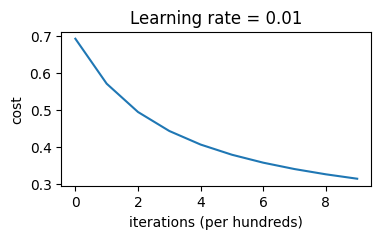

In [135]:
def plot_learning_curve(costs, learning_rate):
    # plot the learning curve
    plt.figure(figsize=(4,2))
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()    

# plot the learning curve
plot_learning_curve(costs, learning_rate)

#### 6. Prediction on new data

In [136]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (nx, 1)
    b -- bias, a scalar
    X -- data of size (nx, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1] # number of examples
    Y_prediction = np.zeros((1, m)) # initialize the prediction output
    w = w.reshape(X.shape[0], 1) # make sure w is the correct shape, ie. (nx, 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X)+b) # shape of A is (1, m)
    
    for i in range(A.shape[1]): 
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    return Y_prediction

In [137]:
# test the predict function
w, b = params["w"], params["b"]
train_pred = predict(w, b, X_train)
test_pred = predict(w, b, X_test)
print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)
print("shape of train_pred:", train_pred.shape)
print("shape of test_pred:", test_pred.shape)

# Print train accuracy
print("Train Accuracy: {} %".format(100 - np.mean(np.abs(train_pred - y_train)) * 100))
print("Test Accuracy: {} %".format(100 - np.mean(np.abs(test_pred - y_test)) * 100))

shape of y_train: (1, 400)
shape of y_test: (1, 100)
shape of train_pred: (1, 400)
shape of test_pred: (1, 100)
Train Accuracy: 93.0 %
Test Accuracy: 94.0 %


#### 7. model

In [138]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w, b , X_test)
    Y_prediction_train = predict(w, b , X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [139]:
logistic_regression_model = model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.624758
Cost after iteration 200: 0.571223
Cost after iteration 300: 0.528755
Cost after iteration 400: 0.494501
Cost after iteration 500: 0.466397
Cost after iteration 600: 0.442966
Cost after iteration 700: 0.423145
Cost after iteration 800: 0.406158
Cost after iteration 900: 0.391433
Cost after iteration 1000: 0.378540
Cost after iteration 1100: 0.367149
Cost after iteration 1200: 0.357005
Cost after iteration 1300: 0.347907
Cost after iteration 1400: 0.339697
Cost after iteration 1500: 0.332246
Cost after iteration 1600: 0.325450
Cost after iteration 1700: 0.319221
Cost after iteration 1800: 0.313489
Cost after iteration 1900: 0.308194
Final cost after iteration 1999: 0.303333
Parameter learnt: 
w =  [[ 1.42658996]
 [ 0.91953249]
 [-0.03067701]
 [ 0.07020318]]
b =  0.6447678742182477
train accuracy: 93.0 %
test accuracy: 94.0 %


#### 8. learning curve on model

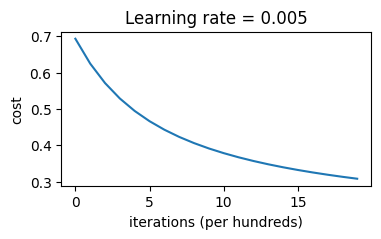

In [140]:
plot_learning_curve(logistic_regression_model["costs"], logistic_regression_model["learning_rate"])

#### 9. plot decision boundary

In [141]:
# plot the decision boundary for train data
def plot_decision_boundary(X, Y, w, b):
    
    def predict_for_plot(X, w, b):
        Z = np.dot(w.T, X) + b
        A = 1 / (1 + np.exp(-Z))
        Y_pred = (A > 0.5).astype(int)
        return Y_pred

    plt.figure(figsize=(6,4))
    # Plot data points
    plt.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap=plt.cm.coolwarm, s=40, marker='o', edgecolors='k')

    # Create meshgrid for decision boundary
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions on meshgrid
    Z = predict_for_plot(np.c_[xx.ravel(), yy.ravel()].T, w[:2, :], b)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2) # decision boundary
    
    # Add labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')

    # Show plot
    plt.show()

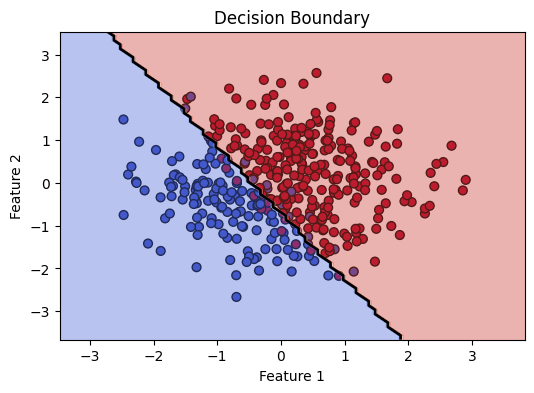

In [142]:
w = logistic_regression_model["w"]
b = logistic_regression_model["b"]
plot_decision_boundary(X_train, y_train, w, b)

#### 10. final model on various datasets

In [143]:
def try_some_std_dataset(name, m = 500):
    X, Y = get_std_dataset(name, m)
    plot_std_dataset(X, Y)

    # invert and split
    X = X.T
    Y = Y.T
    X_train, X_test, y_train, y_test = split_data(X, Y)
    
    # model
    logistic_regression_model = model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.005, print_cost=True)

    # plot learning curve
    plot_learning_curve(logistic_regression_model["costs"], logistic_regression_model["learning_rate"])

    # plot decision boundary
    plot_decision_boundary(X_train, y_train, logistic_regression_model["w"], logistic_regression_model["b"])

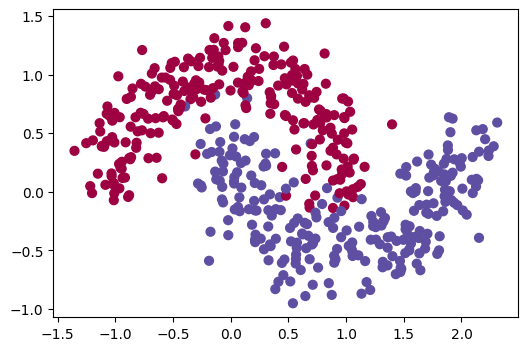

X_train shape: (2, 400)
y_train shape: (1, 400)
X_test shape: (2, 100)
y_test shape: (1, 100)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.647428
Cost after iteration 200: 0.609889
Cost after iteration 300: 0.578742
Cost after iteration 400: 0.552622
Cost after iteration 500: 0.530490
Cost after iteration 600: 0.511556
Cost after iteration 700: 0.495212
Cost after iteration 800: 0.480988
Cost after iteration 900: 0.468517
Cost after iteration 1000: 0.457505
Cost after iteration 1100: 0.447721
Cost after iteration 1200: 0.438977
Cost after iteration 1300: 0.431119
Cost after iteration 1400: 0.424023
Cost after iteration 1500: 0.417585
Cost after iteration 1600: 0.411718
Cost after iteration 1700: 0.406350
Cost after iteration 1800: 0.401421
Cost after iteration 1900: 0.396878
Final cost after iteration 1999: 0.392718
Parameter learnt: 
w =  [[ 0.98763637]
 [-1.25927848]]
b =  -0.1321944805901583
train accuracy: 82.25 %
test accuracy: 81.0 %


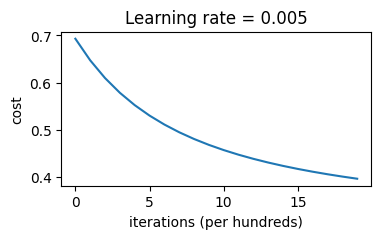

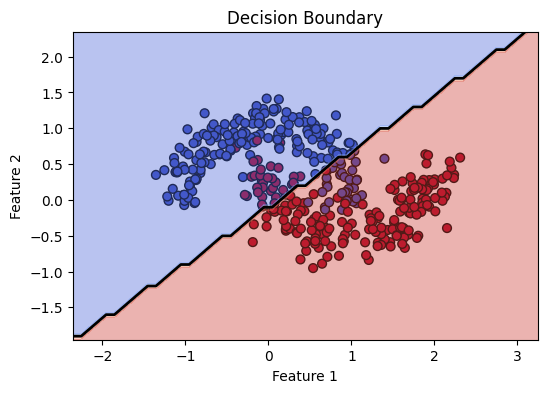

In [144]:
name = "noisy_moons"
m = 500
try_some_std_dataset(name, m)

## Cat Vs Non-Cat Classification

In [145]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [146]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

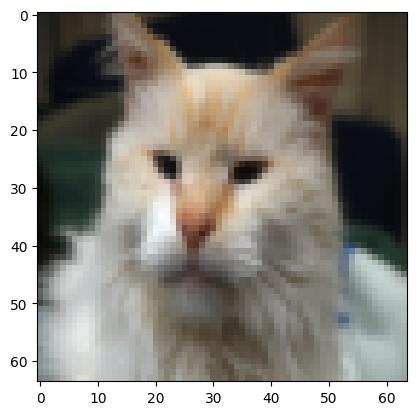

In [147]:
# Example of a picture
index = 27
plt.imshow(train_set_x_orig[index])

In [148]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [149]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [150]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [151]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508


Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Final cost after iteration 1999: 0.135659
Parameter learnt: 
w =  [[ 0.00961402]
 [-0.0264683 ]
 [-0.01226513]
 ...
 [-0.01144453]
 [-0.02944783]
 [ 0.02378106]]
b =  -0.01590624399969297
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


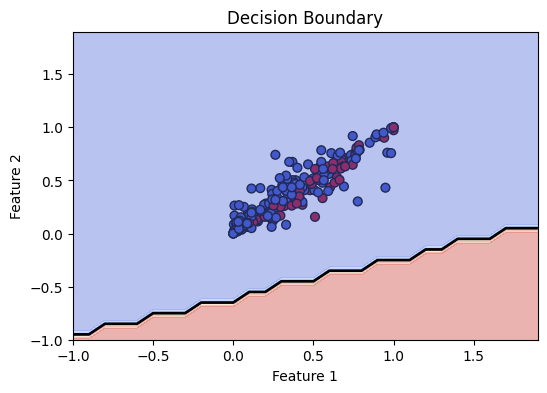

In [152]:
plot_decision_boundary(train_set_x, train_set_y, logistic_regression_model["w"], logistic_regression_model["b"])

y = 1, you predicted that it is a "cat" picture.


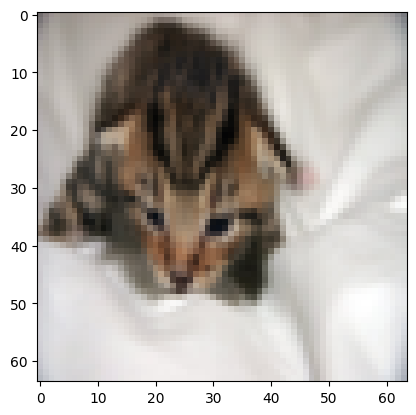

In [153]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

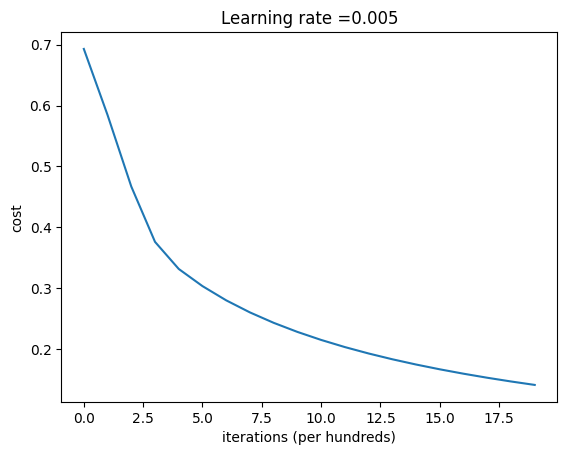

In [154]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()